## Setup

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='2'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf
import keras
import numpy.matlib
import mat73
import colorcet as cc

from numpy import asarray
from scipy import stats, signal, io
from scipy.ndimage import median_filter as medfilt

from sklearn.metrics import r2_score, normalized_mutual_info_score as nmi, accuracy_score as acc
from sklearn.utils.extmath import randomized_svd as rsvd

from sklearn.preprocessing import normalize, StandardScaler
from sklearn.mixture import GaussianMixture


from utils import tic, toc, generate_color_gradient, hankel_matrix, scaler, legendre_polys, find_opt_lag
from models import linear_regression, VAE

%matplotlib inline

2025-02-01 17:04:41.313054: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-01 17:04:41.443923: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-01 17:04:41.930219: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2025-02-01 17:04:41.930272: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such 

In [3]:
from matplotlib.colors import ListedColormap
import seaborn as sns
palette = sns.color_palette("husl", 6)
cmap = ListedColormap(colors=palette)

In [4]:
font = {'family' : 'arial',
        'size'   : 16}
plt.rc('font', **font)

In [5]:
def plot_allen(ax):
    allen_ccf = mat73.loadmat(data_dir + '/allen_ccf_overlay.mat')['allen_ccf']
    for i in range(len(allen_ccf)):
        temp1 = allen_ccf[i]
        ax.plot(temp1[:,0],temp1[:,1],'w',lw=.5)

## Load and preprocess data

In [6]:
def load_pupil(subj,filt=True):
    data_dict = mat73.loadmat(data_dir + '/' + str(subj) + '_pupil.mat')
    pupil = data_dict['pupil'].reshape(-1,1)
    pupil = medfilt(pupil,21)
    
    if filt:
        Fs = 20
        dt = 1/Fs
        sos = signal.butter(1, [.01,.2],btype = 'bandpass', output = 'sos', fs = Fs)
        pupil = signal.sosfiltfilt(sos, pupil, axis=0)
    
    pupil = pupil[1000:-800,:]
    
    pupil = StandardScaler(with_std=False).fit_transform(pupil)

    return pupil

In [7]:
def load_brain(subj,modality='jrgeco',filt=True):
    data_dict = mat73.loadmat(data_dir + '/' + str(subj) + '_' + modality + '.mat')
    brain = data_dict['data'][:,mask_long]

    if filt:
        Fs = 20
        dt = 1/Fs
        sos = signal.butter(1, [.01,.2],btype = 'bandpass', output = 'sos', fs = Fs)
        brain = signal.sosfiltfilt(sos, brain, axis=0)
        
    brain = brain[1000:-800,:]
    
    brain = StandardScaler(with_std=False).fit_transform(brain)

    return brain

In [8]:
data_dir = '/home/ryanr/widefield'
outdir = '/home/ryanr/Allen/arousal_final/model_predictions'
figdir = '/home/ryanr/Allen/arousal_final/figs'
mask = io.loadmat(data_dir+'/newmask.mat')
mask = mask["newmask"]
mask.dtype = bool
mask_long = mask.reshape(16384,order='F')
allen_ccf = mat73.loadmat(data_dir + '/allen_ccf_overlay.mat')['allen_ccf']

In [9]:
from numpy.random import seed
seed(1)
keras.utils.set_random_seed(1)

## Analysis

In [10]:
## Set modeling parameters

subjects = [4,5,6,7,8,9,10]
Fs = 20 # sampling frequency
dt = 1/Fs
stackmax = 100 # Hankel row dimension (i.e., number of time shifts)
spacing = 3 # number of samples separating each row
r = 10 # number of modes of the Hankel matrix to keep (used for projection onto top r Legendre polynomials)
z_n = 3 # number of latent dimensions used for VAE
num_epochs = 200 # number of training epochs
lr = .001
beta = .1 # beta weight for KL loss in VAE training
anneal_step = 2000 # determines rate at which KL loss is increased during training
pretrained_enc = []

In [11]:
## Create group files

xtrains = []
pupils = []
ytrains = []
yscales = []
lags = []

modality='jrgeco'

for s in range(len(subjects)):
    
    tic()
    
    subj = subjects[s]
    
    # Load data
    pupil = load_pupil(subj)
    brain = load_brain(subj,modality)
    
    # Compute lags for later
    lag_range = 5 # range over which to look for optimal lag between pupil and brain cross-correlation (in seconds)
    lag_range = int(lag_range/dt)
    lag,_,_ = find_opt_lag(pupil,np.mean(brain,axis=1),lag_range)
    lags.append(lag)
          
    ## Time delay embedding
    polys = legendre_polys(r, stackmax)
    Hp = hankel_matrix(pupil.T,stackmax,spacing)
    xtrain = Hp.T@polys
    xtrain = np.concatenate((xtrain,Hp.T[:,-1:]),axis=1)
    ytrain = brain[spacing*(stackmax-1):,:]
        
    xtrain,_ = scaler(xtrain)
    ytrain, scale_y = scaler(ytrain)
    
    xtrains.append(xtrain)
    ytrains.append(ytrain)
    yscales.append(scale_y)
    
    toc()


Elapsed time is 8.253347158432007 seconds.
Elapsed time is 8.182106971740723 seconds.
Elapsed time is 8.07849645614624 seconds.
Elapsed time is 8.148396492004395 seconds.
Elapsed time is 8.295969486236572 seconds.
Elapsed time is 8.303235530853271 seconds.
Elapsed time is 8.090065479278564 seconds.


In [12]:
# Leave-one-out crossval

num_PCs = 10
modality = 'jrgeco'

#ytrains = np.load(outdir + '/group_' + modality + '_ytrains.npy',allow_pickle=True)
#lags = np.load(outdir + '/group_' + modality + '_lags.npy').tolist()

s=0

tic()

subj = subjects[s]

# Apply the median lag adjustment to all mice
lag = int(np.median(lags[:s] + lags[s+1:]))

xtrains_aligned = xtrains.copy()
ytrains_aligned = ytrains.copy()

for ss in range(len(xtrains)):
    xtrains_aligned[ss] = xtrains_aligned[ss][lag:,:]
    ytrains_aligned[ss] = ytrains_aligned[ss][:-lag,:]

train_x = np.concatenate(xtrains_aligned[:s] + xtrains_aligned[s+1:], axis=0)
train_y = np.concatenate(ytrains_aligned[:s] + ytrains_aligned[s+1:], axis=0)

test_x = xtrains_aligned[s]
test_y = ytrains_aligned[s]

# Project to top group PCs for efficient training
u,sigma,vh = rsvd(train_y, n_components=num_PCs)

train_y = train_y@vh.T[:,:num_PCs]
test_y = test_y@vh.T[:,:num_PCs]

# Preprocessing
train_x_sc, scale_x = scaler(train_x)
train_y_sc, scale_y = scaler(train_y)

# Train model
r_squared, model, encoder, decoder = VAE(train_x_sc, train_y_sc, latent_dim=z_n, beta=beta,
                                        num_epochs=num_epochs, anneal_step=anneal_step, lr=lr, verbose=False)

test_x_sc,_ = scaler(test_x, scale_x)

# Save files
encoder.save_weights(outdir + '/' + str(subj) + '_' + modality + '_encoder_weights_z3.h5')
decoder.save_weights(outdir + '/' + str(subj) + '_' + modality + '_decoder_weights_z3.h5')

toc()

2025-02-01 17:05:49.945541: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-01 17:05:50.517339: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9627 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:67:00.0, compute capability: 7.5


Elapsed time is 68.48106551170349 seconds.


# GMM

## Example mouse

In [13]:
subj = subjects[0]

vh = np.load(outdir + '/../PCs/' + str(subj) + '_' + modality + '_spatial_modes.npy')
    
data = np.load(outdir + '/' + str(subj) + '_' + modality + '_ytest.npy')

num_PCs = 3

# Projection
data_z = normalize(data)
data_z = data_z@vh.T[:,:num_PCs]

gmm = GaussianMixture(n_components=6, covariance_type='full', n_init=50, random_state=0)
gmm.fit(data_z)

states = gmm.predict(data_z)

In [14]:
cmap.colors

[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.7350228985632719, 0.5952719904750953, 0.1944419133847522),
 (0.3126890019504329, 0.6928754610296064, 0.1923704830330379),
 (0.21044753832183283, 0.6773105080456748, 0.6433941168468681),
 (0.23299120924703914, 0.639586552066035, 0.9260706093977744),
 (0.9082572436765556, 0.40195790729656516, 0.9576909250290225)]

In [15]:
state_key = np.array([1,4,3,0,5,2]) #desired order
states_reassign = states.copy()
for old_state, new_state in zip(np.unique(states), state_key):
    states_reassign[states==old_state] = new_state
    
state_key

array([1, 4, 3, 0, 5, 2])

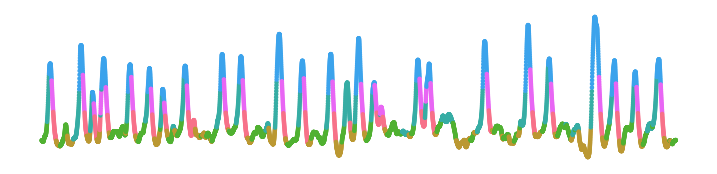

In [16]:
start = 872
lim = 8374-start
plt.figure(figsize=(9,2))
plt.scatter(np.arange(lim),(data@vh.T[:,:3])[start:start+lim,0],5,c=states_reassign[start:start+lim],cmap=cmap)
plt.axis('off')

plt.savefig(figdir + '/gmm_pupil_traj.pdf', dpi=300, transparent=True)

plt.show()

In [17]:
def save_view_settings(ax):
    view_settings = {
        'xlim': ax.get_xlim(),
        'ylim': ax.get_ylim(),
        'zlim': ax.get_zlim(),
        'azim': ax.azim,
        'elev': ax.elev
    }
    return view_settings

def restore_view_settings(ax, view_settings):
    ax.set_xlim(view_settings['xlim'])
    ax.set_ylim(view_settings['ylim'])
    ax.set_zlim(view_settings['zlim'])
    ax.view_init(elev=view_settings['elev'], azim=view_settings['azim'])

In [18]:
view_settings = {'xlim': (-1.4411856769982387, 1.7605355064768373),
 'ylim': (-1.5985736329322355, 5.0870895823298765),
 'zlim': (-1.0177150179458296, 0.8810221951252579),
 'azim': -45.38961038961036,
 'elev': 41.6883116883116}

In [19]:
# %matplotlib notebook # for interactive plotter

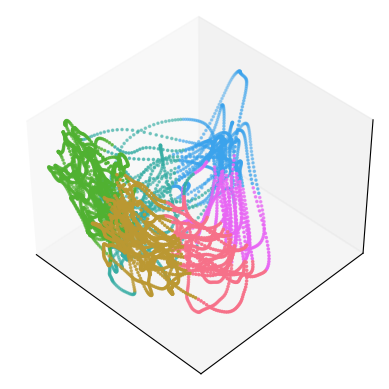

In [20]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
traj = data@vh.T[:,:3]

#colors=states.copy()
colors=states_reassign.copy()
ax.scatter(traj[start:start+lim,1],traj[start:start+lim,0],traj[start:start+lim,2],s=10,marker ='.',c=colors[start:start+lim],cmap=cmap)

ax.grid(False)

restore_view_settings(ax,view_settings)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

plt.savefig(figdir + '/gmm_3d_wf.pdf', dpi=300, transparent=True)

plt.show()

In [21]:
#view_settings = save_view_settings(ax)

### Generate 3D embedding for example visualization

In [22]:
traj = encoder.predict(test_x_sc)[0]

309/309 [==============================] - 1s 2ms/step


In [23]:
view_settings = {'xlim': (-1.1371140778064728, 1.1717828810214996),
 'ylim': (-1.3500077664852141, 1.3208471477031707),
 'zlim': (-1.1754853188991548, 0.7324398219585418),
 'azim': -111.62337662337632,
 'elev': -119.0259740259743}

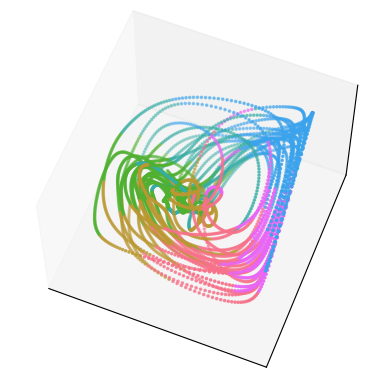

In [24]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

colors=states_reassign.copy()
ax.scatter(traj[start:start+lim,1],traj[start:start+lim,2],traj[start:start+lim,0],s=10,marker ='.',c=colors[start:start+lim],cmap=cmap)

ax.grid(False)

restore_view_settings(ax,view_settings)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

plt.savefig(figdir + '/gmm_3d_delay1.pdf', dpi=300, transparent=True)

plt.show()

In [25]:
view_settings = {'xlim': (-1.1371142148971558, 1.1717831373214722),
 'ylim': (-1.350007528066635, 1.3208473861217498),
 'zlim': (-1.1754850685596465, 0.7324398100376129),
 'azim': -790.0324675324682,
 'elev': -127.79220779220769}

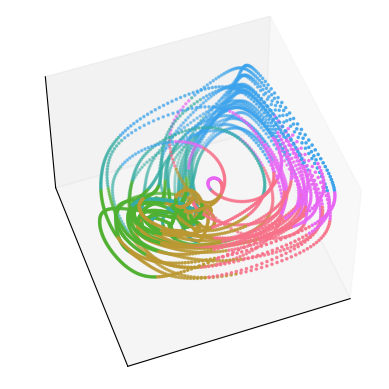

In [26]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

colors=states_reassign.copy()
ax.scatter(traj[start:start+lim,1],traj[start:start+lim,2],traj[start:start+lim,0],s=10,marker ='.',c=colors[start:start+lim],cmap=cmap)

ax.grid(False)

restore_view_settings(ax,view_settings)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

plt.savefig(figdir + '/gmm_3d_delay2.pdf', dpi=300, transparent=True)

plt.show()

In [27]:
#view_settings = save_view_settings(ax)

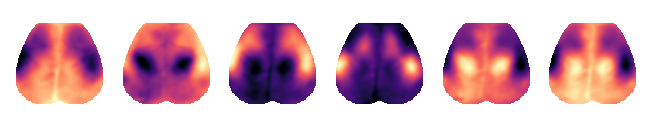

In [28]:
fig, axes = plt.subplots(1,6,layout='compressed')

axes = axes.flatten()

for i, ax in enumerate(axes):
        
    #temp = np.mean(data[(states_reassign==i),:],axis=0)
    temp = gmm.means_[state_key==i,:]@vh[:num_PCs,:]
    temp = temp.reshape(-1,1)
    outmat1 = np.zeros([16384,1], dtype=np.single)
    outmat1[mask_long] = temp
    outmat1 = np.ma.masked_where(outmat1==0, outmat1)
    outmat1 = outmat1.reshape(128,128,order='F')
    
    ax.imshow(outmat1, cmap = 'magma')
    
    ax.axis('off')
    
    plt.savefig(figdir + '/gmm_maps.pdf', dpi=300, transparent=True)

plt.show()

## Group cluster

In [29]:
font = {'family' : 'arial',
        'size'   : 16}
plt.rc('font', **font)

def barplotter(Ks, decode_scores, subjects, modality='jrgeco'):
    
    line_colors = generate_color_gradient(len(subjects)+3, modality)

    fig, ax = plt.subplots(figsize=(5, 5))

    for category in range(len(Ks)):
        for group in range(decode_scores.shape[2]):

            # Background bar
            bar_width = 0.2
            x_values = np.arange(len(Ks))*1.2
            ax.bar(.03+x_values-.2, np.mean(decode_scores,axis=0).T[0],.3,color=[0, 0, 0, 0],edgecolor='k',linewidth=.2)
            ax.bar(.03+x_values+.1, np.mean(decode_scores,axis=0).T[1],.3,color=[0, 0, 0, 0],edgecolor='k',linewidth=.2)        
            ax.bar(.03+x_values+.4, np.mean(decode_scores,axis=0).T[2],.3,color=[0, 0, 0, 0],edgecolor='k',linewidth=.2)

            # Scatter
            x_values = np.zeros(decode_scores.shape[0])+1.2*category
            y_values = decode_scores[:, category, group]

            adjusted_x = x_values-.2 + .3 * group

            for i in range(decode_scores.shape[0]):
                ax.scatter(adjusted_x[i]+.01*i, y_values[i],12,color=line_colors[i])

    for category in range(len(Ks)):

        x_values = np.zeros(decode_scores.shape[0])+1.2*category

        for i in range(decode_scores.shape[0]):
            ax.plot([.01*i+x_values-.2,.01*i+x_values+.1,.01*i+x_values+.4],decode_scores[i,category,:],c=line_colors[i],lw=1,alpha=.1)

    plt.xlabel('# of clusters')

    ax.set_xticks(.1+1.2*np.arange(len(Ks)), labels = Ks)

    #plt.show()

In [30]:
modality = 'jrgeco'
num_PCs = 3
Ks = [2,3,4,5,6]
decode_scores = np.zeros([len(subjects),len(Ks),3])

for s in range(len(subjects)):
    
    tic()
    
    subj = subjects[s]
    
    vh = np.load(outdir + '/../PCs/' + str(subj) + '_' + modality + '_spatial_modes.npy')
    
    ytest = np.load(outdir + '/' + str(subj) + '_' + modality + '_ytest.npy')
    ytest_hat1 = np.load(outdir + '/' + str(subj) + '_' + modality + '_nodelay_lin_ytest_hat.npy')
    ytest_hat2 = np.load(outdir + '/' + str(subj) + '_' + modality + '_delay_nonlin_ytest_hat.npy')

    data = normalize(ytest)
    data1 = normalize(ytest_hat1)
    data2 = normalize(ytest_hat2)
    
    # Projection
    data = data@vh.T[:,:num_PCs]
    data1 = data1@vh.T[:,:num_PCs]
    data2 = data2@vh.T[:,:num_PCs]
    
    # Clustering
    for k in range(len(Ks)):
        
        gmm = GaussianMixture(n_components=Ks[k],covariance_type='full',n_init=10,random_state=0)
        
        gmm.fit(data)
        states = gmm.predict(data)
        states1 = gmm.predict(data1)
        states2 = gmm.predict(data2)
        states_dummy = np.full(len(states),np.argmax(np.bincount(states)))
        #states_dummy = np.full(len(states),np.argmax(gmm.weights_)) # should be same

        decode_scores[s,k,1] = acc(states,states1)
        decode_scores[s,k,2] = acc(states,states2)
        decode_scores[s,k,0] = acc(states,states_dummy)
    
    toc()

Elapsed time is 11.679193258285522 seconds.
Elapsed time is 12.698379039764404 seconds.
Elapsed time is 11.144803524017334 seconds.
Elapsed time is 11.539655685424805 seconds.
Elapsed time is 11.33656120300293 seconds.
Elapsed time is 13.01842474937439 seconds.
Elapsed time is 11.387821674346924 seconds.


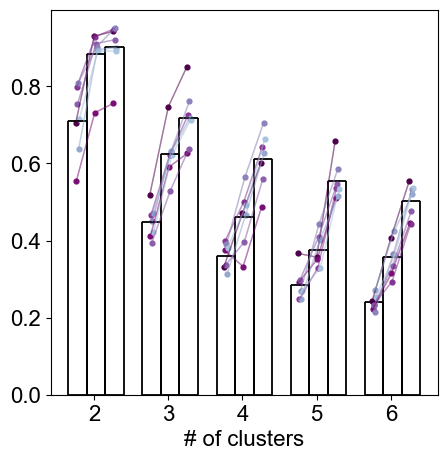

In [31]:
barplotter(Ks,decode_scores,subjects,modality)
plt.savefig(figdir + '/gmm_main.pdf', dpi=300, transparent=True)
plt.show()

## More states w/o PC whitening; spherical cov prior (for supplement)

In [32]:
modality = 'jrgeco'
num_PCs = 3
Ks = [2,4,6,8,10]
decode_scores = np.zeros([len(subjects),len(Ks),3])

for s in range(len(subjects)):
    
    tic()
    
    subj = subjects[s]
    
    vh = np.load(outdir + '/../PCs/' + str(subj) + '_' + modality + '_spatial_modes.npy')
    
    ytest = np.load(outdir + '/' + str(subj) + '_' + modality + '_ytest.npy')
    ytest_hat1 = np.load(outdir + '/' + str(subj) + '_' + modality + '_nodelay_lin_ytest_hat.npy')
    ytest_hat2 = np.load(outdir + '/' + str(subj) + '_' + modality + '_delay_nonlin_ytest_hat.npy')

    data = normalize(ytest)
    data1 = normalize(ytest_hat1)
    data2 = normalize(ytest_hat2)
    
    # Projection
    data = data@vh.T[:,:num_PCs]
    data1 = data1@vh.T[:,:num_PCs]
    data2 = data2@vh.T[:,:num_PCs]
    
    # Clustering
    for k in range(len(Ks)):
        
        gmm = GaussianMixture(n_components=Ks[k],covariance_type='spherical',n_init=10,random_state=0)
        
        gmm.fit(data)
        states = gmm.predict(data)
        states1 = gmm.predict(data1)
        states2 = gmm.predict(data2)
        states_dummy = np.full(len(states),np.argmax(np.bincount(states)))
        #states_dummy = np.full(len(states),np.argmax(gmm.weights_)) # should be same

        decode_scores[s,k,1] = acc(states,states1)
        decode_scores[s,k,2] = acc(states,states2)
        decode_scores[s,k,0] = acc(states,states_dummy)
    
    toc()

Elapsed time is 10.734330415725708 seconds.
Elapsed time is 11.044031858444214 seconds.
Elapsed time is 10.748995304107666 seconds.
Elapsed time is 10.959173202514648 seconds.
Elapsed time is 11.477193593978882 seconds.
Elapsed time is 10.586522340774536 seconds.
Elapsed time is 10.41329050064087 seconds.


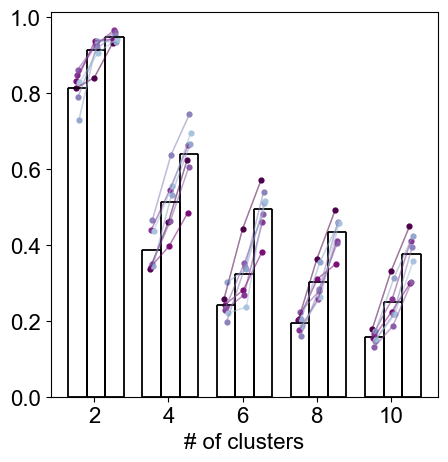

In [33]:
barplotter(Ks,decode_scores,subjects,modality)
plt.savefig(figdir + '/gmm_10state_nowhite.pdf', dpi=300, transparent=True)
plt.show()

## More states w/ PC whitening; spherical cov prior (for supplement)

In [34]:
modality = 'jrgeco'
num_PCs = 3
Ks = [2,4,6,8,10]
decode_scores = np.zeros([len(subjects),len(Ks),3])

for s in range(len(subjects)):
    
    tic()
    
    subj = subjects[s]
    
    vh = np.load(outdir + '/../PCs/' + str(subj) + '_' + modality + '_spatial_modes.npy')
    
    ytest = np.load(outdir + '/' + str(subj) + '_' + modality + '_ytest.npy')
    ytest_hat1 = np.load(outdir + '/' + str(subj) + '_' + modality + '_nodelay_lin_ytest_hat.npy')
    ytest_hat2 = np.load(outdir + '/' + str(subj) + '_' + modality + '_delay_nonlin_ytest_hat.npy')

    data = normalize(ytest)
    data1 = normalize(ytest_hat1)
    data2 = normalize(ytest_hat2)
    
    # Projection
    data = data@vh.T[:,:num_PCs]
    data1 = data1@vh.T[:,:num_PCs]
    data2 = data2@vh.T[:,:num_PCs]
        
    # PC whitening (feature-wise standardization)
    data = stats.zscore(data,axis=0)
    data1 = stats.zscore(data1,axis=0)
    data2 = stats.zscore(data2,axis=0)
    
    # Clustering
    for k in range(len(Ks)):
        
        gmm = GaussianMixture(n_components=Ks[k],covariance_type='spherical',n_init=10,random_state=0)
        
        gmm.fit(data)
        states = gmm.predict(data)
        states1 = gmm.predict(data1)
        states2 = gmm.predict(data2)
        states_dummy = np.full(len(states),np.argmax(np.bincount(states)))
        #states_dummy = np.full(len(states),np.argmax(gmm.weights_)) # should be same

        decode_scores[s,k,1] = acc(states,states1)
        decode_scores[s,k,2] = acc(states,states2)
        decode_scores[s,k,0] = acc(states,states_dummy)
    
    toc()

Elapsed time is 10.547060012817383 seconds.
Elapsed time is 11.793609142303467 seconds.
Elapsed time is 10.723431825637817 seconds.
Elapsed time is 10.898752212524414 seconds.
Elapsed time is 10.942373275756836 seconds.
Elapsed time is 11.084555387496948 seconds.
Elapsed time is 10.863625288009644 seconds.


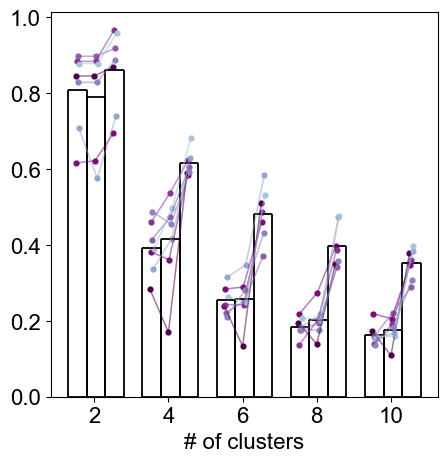

In [35]:
barplotter(Ks,decode_scores,subjects,modality)
plt.savefig(figdir + '/gmm_10state_white.pdf', dpi=300, transparent=True)
plt.show()